En este notebook probaremos modelos transformando el dataset limpio (eliminaremos outliers y descartaremos dimesiones).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split as tts

In [2]:
from scipy.stats import linregress

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
data = pd.read_csv('data/clean_train.csv')

Comprobamos **valores atípicos** en el precio.

In [4]:
data.price.values

array([ 87., 250., 151., ..., 114., 416., 292.])

In [5]:
precios = []

for e in data.price.values:
    precios.append(e)

In [6]:
precios.sort()

precios[:10] 

# Encontramos 4 ceros que pueden provocar desajustes en el entrenamiento del modelo.

# Eliminamos estos registros.

[0.0, 0.0, 0.0, 0.0, 20.0, 22.0, 22.0, 22.0, 24.0, 24.0]

In [7]:
precios.sort(reverse=True)

precios[:15]

# Encontramos dos valores muy elevados que pueden provocar desajustes en el entrenamiento del modelo.

# Eliminamos estos registros.

[6477.0,
 6477.0,
 1818.0,
 1400.0,
 1400.0,
 1399.0,
 1190.0,
 1057.0,
 1000.0,
 999.0,
 981.0,
 950.0,
 904.0,
 890.0,
 861.0]

In [8]:
data = data.drop(data[data.price > 6000].index)

In [9]:
# Comprobamos que se han eliminado.

precios = []

for e in data.price.values:
    precios.append(e)

precios.sort(reverse=True)

precios[:5]

[1818.0, 1400.0, 1400.0, 1399.0, 1190.0]

In [10]:
data = data.drop(data[data.price == 0].index)

In [11]:
# Comprobamos que se han eliminado donde price = 0.

precios = []

for e in data.price.values:
    precios.append(e)

precios.sort()

precios[:5]

[20.0, 22.0, 22.0, 22.0, 24.0]

Ya tenemos el dataset sin registros donde el precio puede desajustar el modelo.

Ahora analizaremos cuáles son las **dimensiones** de mayor importancia para descartar aquellas que no aporten suficiente valor al modelo. Esto lo haremos a través del modelo XGBoost, el cual nos proporciona la importancia relativa de las características.

In [12]:
X = data.drop('price', axis=1)
y = data.price

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [15]:
from xgboost import XGBRegressor
from matplotlib import pyplot

/home/mario/miniconda3/envs/ironhack/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [17]:
model = XGBRegressor()
model.fit(X, y)

/home/mario/miniconda3/envs/ironhack/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [135]:
# feature importance
print(model.feature_importances_)

[0.01030624 0.00816413 0.01446615 0.01726599 0.01842247 0.01434449
 0.01718605 0.16427329 0.03781392 0.02325239 0.01596333 0.01483155
 0.01223045 0.00922952 0.01525213 0.00324664 0.01313893 0.00530087
 0.04347727 0.02556247 0.07519017 0.         0.00616697 0.01537455
 0.         0.         0.00207077 0.00262358 0.05322443 0.00628731
 0.00972577 0.02325671 0.0206045  0.00567559 0.00353627 0.02388413
 0.00863596 0.13370122 0.02447254 0.10069142 0.00114981]


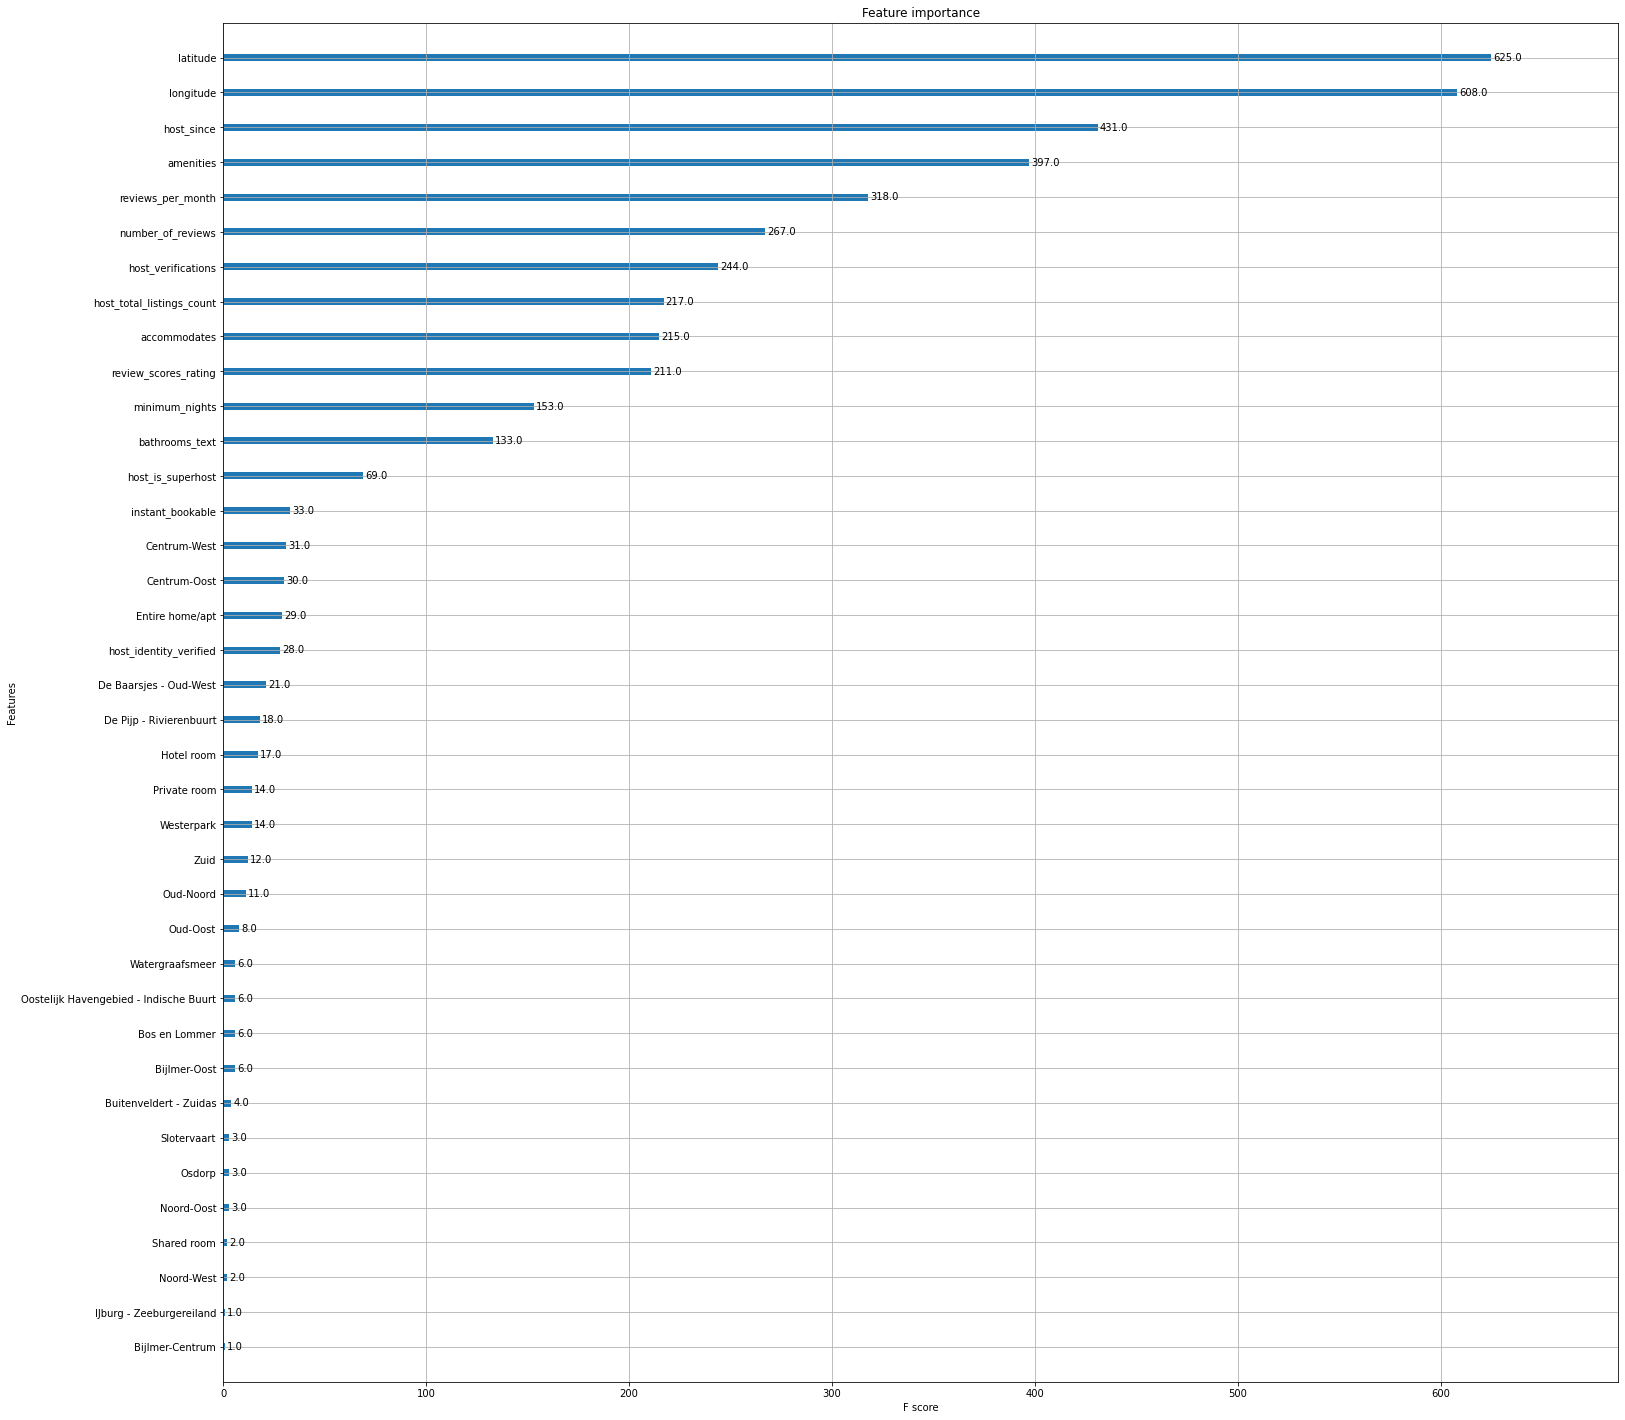

In [29]:
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(25., 25.)

Observamos que la importancia de las características (medida en F score) cambia muchísimo de unas a otras. 

Lo que haremos será quedarnos con aquellas que tienen mayor importancia y descartar las que no lo tienen (si todo va bien, esto debería mejorar la calidad de nuestro modelo).

Probamos estableciendo un umbral de F Score > 65.

Filtramos el dataset y utilizamos el modelo sobre el reajuste.

In [54]:
umbral_65 = data[['latitude', 'longitude', 'host_since', 'amenities', 'reviews_per_month',
                   'number_of_reviews', 'host_verifications', 'host_total_listings_count',
                   'accommodates', 'review_scores_rating', 'minimum_nights', 'bathrooms_text', 'host_is_superhost',
                   'price']]

In [46]:
def regre(modelo):
    
    modelo.fit(X_train, y_train)
    
    train_score=modelo.score(X_train, y_train)  # R2
    test_score=modelo.score(X_test, y_test)
    
    print(modelo)
    print('Train R2:', train_score)
    print('Test R2:', test_score)
    
    return modelo

In [47]:
# Probamos XGBR sobre el dataset original.

xgbr = XGBRegressor()

xgbr = regre(xgbr) 

/home/mario/miniconda3/envs/ironhack/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Train R2: 0.9603692472867917
Test R2: 0.33105184819507605


/home/mario/miniconda3/envs/ironhack/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [55]:
# Probamos XGBR sobre el nuevo dataset.

X2 = umbral_65.drop('price', axis=1)
y2 = umbral_65.price

X2_train, X2_test, y2_train, y2_test = tts(X2, y2, test_size=0.2, train_size=0.8, random_state=42)

In [52]:
def regre2(modelo):
    
    modelo.fit(X2_train, y2_train)
    
    train_score=modelo.score(X2_train, y2_train)  # R2
    test_score=modelo.score(X2_test, y2_test)
    
    print(modelo)
    print('Train R2:', train_score)
    print('Test R2:', test_score)
    
    return modelo

In [56]:
xgbr = XGBRegressor()

xgbr = regre2(xgbr) 

/home/mario/miniconda3/envs/ironhack/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Train R2: 0.9541157207842486
Test R2: 0.3193772145103273


/home/mario/miniconda3/envs/ironhack/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


No obtenemos mejoras en este modelo, pero es posible que si lo hagamos en otros.

Probaremos a meter este dataset en H2O para ver si obtenemos algún modelo interesante (mejor a los que ya tenemos).

In [57]:
# Exportamos el dataset.

umbral_65.to_csv('data/train_umbralF_65.csv', index=False)

Probamos h2o sobre el nuevo dataset.

In [60]:
data_h20 = pd.read_csv('data/train_umbralF_65.csv')

In [58]:
import h2o

from h2o.automl import H2OAutoML

In [59]:
# Inicializamos:

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /home/mario/miniconda3/envs/ironhack/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxnjgijk4
  JVM stdout: /tmp/tmpxnjgijk4/h2o_mario_started_from_python.out
  JVM stderr: /tmp/tmpxnjgijk4/h2o_mario_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"7 days, 20 hours and 3 minutes"
H2O_cluster_name:,H2O_from_python_mario_591umk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.869 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [61]:
train, test = tts(data_h20, test_size=0.2, train_size=0.8, random_state=42)

train.to_csv('data/h2o_train_umbralF_65.csv', index=False)

test.to_csv('data/h2o_test_umbralF_65.csv', index=False)

In [62]:
train = h2o.import_file('data/h2o_train_umbralF_65.csv')
test = h2o.import_file('data/h2o_test_umbralF_65.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [63]:
X=train.columns
y='price'
X.remove(y)

In [64]:
# factor para clasificacion binaria

train[y]=train[y]
test[y]=test[y]

## H2O v1

In [65]:
# Ejecutamos h2o.

aml = H2OAutoML(max_models=20, seed=9)
aml.train(x=X, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_5_AutoML_1_20220224_135938

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 4210.386594193614
RMSE: 64.88749181617065
MAE: 38.05906853936196
RMSLE: 0.2993533005817067
R^2: 0.6671267397074456
Mean Residual Deviance: 4210.386594193614
Null degrees of freedom: 3327
Residual degrees of freedom: 3323
Null deviance: 42094599.52764423
Residual deviance: 14012166.585476346
AIC: 37229.64572520986

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 7291.4641420198
RMSE: 85.39007051185635
MAE: 50.081626250947934
RMSLE: 0.38412905281153636
R^2: 0.42353667841153786
Mean Residual Deviance: 7291.4641420198
Null degrees of freedom: 3327
Residual degrees of freedom: 3322
Null deviance: 42127696.75476618
Res

In [66]:
lb =aml.leaderboard

lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_5_AutoML_1_20220224_135938,7291.46,85.3901,7291.46,50.0816,0.384129
StackedEnsemble_BestOfFamily_4_AutoML_1_20220224_135938,7294.1,85.4055,7294.1,50.381,0.388729
StackedEnsemble_AllModels_4_AutoML_1_20220224_135938,7307.76,85.4854,7307.76,50.0591,0.384396
StackedEnsemble_AllModels_7_AutoML_1_20220224_135938,7331.6,85.6248,7331.6,50.2323,0.387438
StackedEnsemble_AllModels_3_AutoML_1_20220224_135938,7347.62,85.7183,7347.62,50.2333,0.385572
StackedEnsemble_AllModels_2_AutoML_1_20220224_135938,7353.15,85.7505,7353.15,50.5383,0.387747
StackedEnsemble_BestOfFamily_8_AutoML_1_20220224_135938,7362.47,85.8048,7362.47,50.376,0.389755
StackedEnsemble_BestOfFamily_3_AutoML_1_20220224_135938,7369.18,85.8439,7369.18,50.7192,0.389254
StackedEnsemble_AllModels_1_AutoML_1_20220224_135938,7393.97,85.9882,7393.97,50.7074,0.38964
StackedEnsemble_BestOfFamily_2_AutoML_1_20220224_135938,7423.56,86.1601,7423.56,50.9748,0.391411


In [136]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_5_AutoML_1_20220224_135938

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 4210.386594193614
RMSE: 64.88749181617065
MAE: 38.05906853936196
RMSLE: 0.2993533005817067
R^2: 0.6671267397074456
Mean Residual Deviance: 4210.386594193614
Null degrees of freedom: 3327
Residual degrees of freedom: 3323
Null deviance: 42094599.52764423
Residual deviance: 14012166.585476346
AIC: 37229.64572520986

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 7291.4641420198
RMSE: 85.39007051185635
MAE: 50.081626250947934
RMSLE: 0.38412905281153636
R^2: 0.42353667841153786
Mean Residual Deviance: 7291.4641420198
Null degrees of freedom: 3327
Residual degrees of freedom: 3322
Null deviance: 42127696.75476618
Residual deviance: 24265992.664641894
AIC: 39059.21658343525


## H2O v2

In [69]:
aml2 = H2OAutoML(max_models=40, seed=1)
aml2.train(x=X, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_3_20220224_143602

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 3705.7800475926333
RMSE: 60.87511846060452
MAE: 35.85273978012612
RMSLE: 0.2846043945953189
R^2: 0.7070209448057795
Mean Residual Deviance: 3705.7800475926333
Null degrees of freedom: 3327
Residual degrees of freedom: 3311
Null deviance: 42094599.52764423
Residual deviance: 12332835.998388283
AIC: 36828.79093115585

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 7269.22851427254
RMSE: 85.25977078477598
MAE: 49.98482390055128
RMSLE: 0.38475040181841824
R^2: 0.42529462764904713
Mean Residual Deviance: 7269.22851427254
Null degrees of freedom: 3327
Residual degrees of freedom: 3312
Null deviance: 42118230.94729333
Res

In [70]:
lb2 =aml2.leaderboard

lb2.head(rows=lb2.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_4_AutoML_3_20220224_143602,7269.23,85.2598,7269.23,49.9848,0.38475
StackedEnsemble_BestOfFamily_8_AutoML_3_20220224_143602,7276.67,85.3034,7276.67,50.1211,0.387901
StackedEnsemble_AllModels_3_AutoML_3_20220224_143602,7292.36,85.3953,7292.36,50.1308,0.386446
StackedEnsemble_BestOfFamily_5_AutoML_3_20220224_143602,7297.89,85.4277,7297.89,50.1479,0.386501
StackedEnsemble_BestOfFamily_4_AutoML_3_20220224_143602,7313.74,85.5204,7313.74,50.3197,nan
StackedEnsemble_AllModels_2_AutoML_3_20220224_143602,7358.27,85.7804,7358.27,50.5876,0.388622
StackedEnsemble_BestOfFamily_2_AutoML_3_20220224_143602,7365.75,85.824,7365.75,50.7226,0.388627
StackedEnsemble_AllModels_7_AutoML_3_20220224_143602,7376.48,85.8865,7376.48,50.3742,0.391573
StackedEnsemble_BestOfFamily_3_AutoML_3_20220224_143602,7378.89,85.9005,7378.89,50.7024,0.38913
StackedEnsemble_AllModels_1_AutoML_3_20220224_143602,7385.37,85.9382,7385.37,50.6808,0.388631


In [74]:
aml2.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_3_20220224_143602

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 3705.7800475926333
RMSE: 60.87511846060452
MAE: 35.85273978012612
RMSLE: 0.2846043945953189
R^2: 0.7070209448057795
Mean Residual Deviance: 3705.7800475926333
Null degrees of freedom: 3327
Residual degrees of freedom: 3311
Null deviance: 42094599.52764423
Residual deviance: 12332835.998388283
AIC: 36828.79093115585

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 7269.22851427254
RMSE: 85.25977078477598
MAE: 49.98482390055128
RMSLE: 0.38475040181841824
R^2: 0.42529462764904713
Mean Residual Deviance: 7269.22851427254
Null degrees of freedom: 3327
Residual degrees of freedom: 3312
Null deviance: 42118230.94729333
Residual deviance: 24191992.495499015
AIC: 39069.052200680475


In [71]:
aml3 = H2OAutoML()
aml3.train(x=X, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_4_20220224_145614

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 3046.1547186894136
RMSE: 55.1919805650188
MAE: 33.18807692584005
RMSLE: 0.2630079781348781
R^2: 0.759170938373203
Mean Residual Deviance: 3046.1547186894136
Null degrees of freedom: 3327
Residual degrees of freedom: 3310
Null deviance: 42094599.52764423
Residual deviance: 10137602.903798368
AIC: 36178.45724266859

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 7209.82688674268
RMSE: 84.91069948329644
MAE: 50.01178778310782
RMSLE: NaN
R^2: 0.42999092167815534
Mean Residual Deviance: 7209.82688674268
Null degrees of freedom: 3327
Residual degrees of freedom: 3310
Null deviance: 42112184.03134992
Residual deviance: 23

## H2O v3

In [72]:
lb3 =aml3.leaderboard

lb3.head(rows=lb3.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_3_AutoML_4_20220224_145614,7209.83,84.9107,7209.83,50.0118,nan
StackedEnsemble_AllModels_4_AutoML_4_20220224_145614,7225.63,85.0037,7225.63,50.0083,nan
StackedEnsemble_BestOfFamily_8_AutoML_4_20220224_145614,7238.3,85.0782,7238.3,49.937,0.383929
StackedEnsemble_AllModels_7_AutoML_4_20220224_145614,7256.28,85.1838,7256.28,49.9422,0.386691
StackedEnsemble_BestOfFamily_4_AutoML_4_20220224_145614,7265.51,85.238,7265.51,50.0028,0.388236
StackedEnsemble_BestOfFamily_9_AutoML_4_20220224_145614,7285.65,85.356,7285.65,50.0845,0.38404
StackedEnsemble_BestOfFamily_5_AutoML_4_20220224_145614,7294.32,85.4068,7294.32,50.2329,0.385812
StackedEnsemble_AllModels_2_AutoML_4_20220224_145614,7313,85.5161,7313,50.4405,0.388053
StackedEnsemble_Best1000_1_AutoML_4_20220224_145614,7328.86,85.6087,7328.86,50.3462,0.39204
XGBoost_lr_search_selection_AutoML_4_20220224_145614_select_grid_model_3,7365.09,85.8201,7365.09,50.5029,0.388904


In [73]:
aml3.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_4_20220224_145614

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 3046.1547186894136
RMSE: 55.1919805650188
MAE: 33.18807692584005
RMSLE: 0.2630079781348781
R^2: 0.759170938373203
Mean Residual Deviance: 3046.1547186894136
Null degrees of freedom: 3327
Residual degrees of freedom: 3310
Null deviance: 42094599.52764423
Residual deviance: 10137602.903798368
AIC: 36178.45724266859

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 7209.82688674268
RMSE: 84.91069948329644
MAE: 50.01178778310782
RMSLE: NaN
R^2: 0.42999092167815534
Mean Residual Deviance: 7209.82688674268
Null degrees of freedom: 3327
Residual degrees of freedom: 3310
Null deviance: 42112184.03134992
Residual deviance: 23994303.879079636
AIC: 39045.74520860531


# Predecimos con los leaders

In [137]:
test_def = pd.read_csv('data/clean_test.csv')

In [138]:
test_superdef = test_def[['latitude', 'longitude', 'host_since', 'amenities', 'reviews_per_month',
                   'number_of_reviews', 'host_verifications', 'host_total_listings_count', 'accommodates',
                   'review_scores_rating', 'minimum_nights', 'bathrooms_text', 'host_is_superhost']]

In [139]:
test_ = h2o.H2OFrame(test_superdef)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


**H2O v1**

In [140]:
pred_ = aml.leader.predict(test_)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [141]:
pred_ = pred_.as_data_frame()

In [142]:
sample_test_h2o = pd.DataFrame()

sample_test_h2o['id'] = [str(i) for i in range(len(pred_))]
sample_test_h2o['price'] = pred_.predict

sample_test_h2o.to_csv("data/predict1.csv", index = False, header=True)

**H2O v2**

In [143]:
pred_ = aml2.leader.predict(test_)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [144]:
pred_ = pred_.as_data_frame()

In [145]:
sample_test_h2o = pd.DataFrame()

sample_test_h2o['id'] = [str(i) for i in range(len(pred_))]
sample_test_h2o['price'] = pred_.predict

sample_test_h2o.to_csv("data/predict2.csv", index = False, header=True)

**H2O v3**

In [146]:
pred_ = aml3.leader.predict(test_)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [147]:
pred_ = pred_.as_data_frame()

In [148]:
sample_test_h2o = pd.DataFrame()

sample_test_h2o['id'] = [str(i) for i in range(len(pred_))]
sample_test_h2o['price'] = pred_.predict

sample_test_h2o.to_csv("data/predict3.csv", index = False, header=True)